In [29]:
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib

sns.set_style("ticks")

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

In [2]:
data_dir = "/workspace/svd_subspace/outputs/ViT-B-32/ablation"
moe_data = defaultdict(list)
for gate_k in [16]:
    for k in [32]:
        for top_k in [1, 2, 4, 8]:
            file_name = f"gate_k={gate_k}_k={k}_top_k={top_k}.json"
            file_name = os.path.join(data_dir, file_name)
            if not os.path.exists(file_name):
                # print(f"File {file_name} does not exist")
                continue
            with open(file_name) as f:
                data = json.load(f)
            moe_data["num_params"].append(data["model_info"]["all_params"])
            moe_data["gate_k"].append(gate_k)
            moe_data["k"].append(k)
            moe_data["top_k"].append(top_k)
            accuracies = {}
            for key in data:
                if key == "model_info":
                    continue
                accuracies[key] = data[key]["accuracy"]
            average_accuracy = np.mean(list(accuracies.values())) * 100
            for key in accuracies:
                moe_data[key].append(accuracies[key])
            moe_data["average"].append(average_accuracy)
moe_data = pd.DataFrame(moe_data)

# 使用 Styler 对象并应用背景颜色渐变
styled_df = moe_data.style.background_gradient(cmap="RdYlGn")

# 显示结果
styled_df

# styled_df:
#
#  	num_params	gate_k	k	top_k	svhn	stanford_cars	resisc45	eurosat	gtsrb	mnist	dtd	sun397	average
# 0	141203712	16	32	1	0.966157	0.748290	0.906508	0.983333	0.971180	0.995400	0.768085	0.715667	88.182758
# 1	141203712	16	32	2	0.962930	0.755130	0.907143	0.983333	0.967854	0.995200	0.734574	0.715315	87.768501
# 2	141203712	16	32	4	0.957322	0.753886	0.903333	0.981481	0.960095	0.994800	0.705851	0.707960	87.059108
# 3	141203712	16	32	8	0.953096	0.748539	0.896984	0.977407	0.954711	0.994900	0.695745	0.702368	86.546874

,num_params,gate_k,k,top_k,svhn,stanford_cars,resisc45,eurosat,gtsrb,mnist,dtd,sun397,average
0,141203712,16,32,1,0.966157,0.748290,0.906508,0.983333,0.971180,0.995400,0.768085,0.715667,88.182758
1,141203712,16,32,2,0.962930,0.755130,0.907143,0.983333,0.967854,0.995200,0.734574,0.715315,87.768501
2,141203712,16,32,4,0.957322,0.753886,0.903333,0.981481,0.960095,0.994800,0.705851,0.707960,87.059108
3,141203712,16,32,8,0.953096,0.748539,0.896984,0.977407,0.954711,0.994900,0.695745,0.702368,86.546874


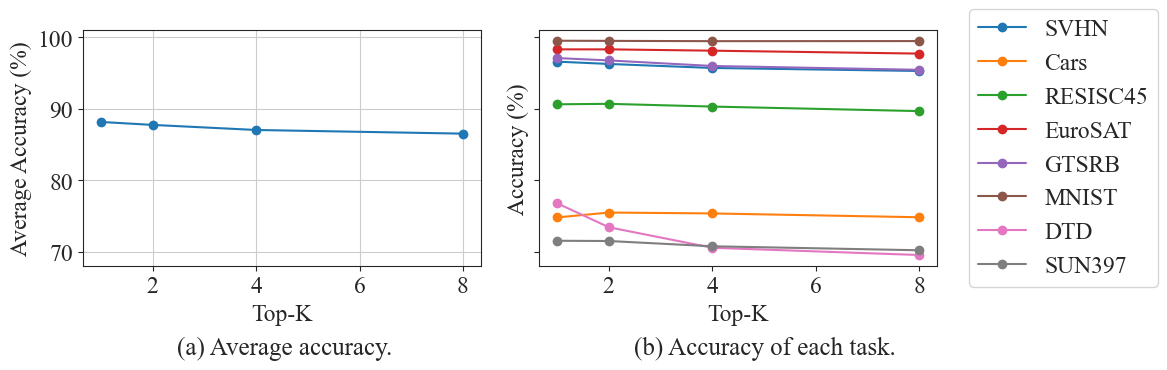

In [54]:
matplotlib.rcParams["font.size"] = 17


# Extract the relevant data
top_k_values = moe_data["top_k"].unique()
average_accuracies = moe_data.groupby("top_k")["average"].mean()
tasks = [
    "svhn",
    "stanford_cars",
    "resisc45",
    "eurosat",
    "gtsrb",
    "mnist",
    "dtd",
    "sun397",
]

# Create subplots
fig, axes = plt.subplots(
    1,
    2,
    figsize=(12, 3.5),
    sharey=True,
)

# Plot the average accuracy
axes[0].plot(top_k_values, average_accuracies, marker="o", linestyle="-")
# axes[0].set_title("Average Accuracy across different top_k values")
axes[0].set_xlabel("Top-K")
axes[0].set_ylabel("Average Accuracy (%)")
axes[0].grid(True)

# Plot the accuracy for each task
for task in tasks:
    axes[1].plot(
        moe_data["top_k"],
        moe_data[task] * 100,
        marker="o",
        linestyle="-",
        label=task.upper()
        .replace("STANFORD_CARS", "Cars")
        .replace("EUROSAT", "EuroSAT"),
    )

# axes[1].set_title("Accuracy of Each Task across Different top_k Values")
axes[1].set_xlabel("Top-K")
axes[1].set_ylabel("Accuracy (%)")
axes[1].legend(
    # place at the right of the plot
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
)
# axes[1].grid(True)
# Add text below each subfigure
fig.text(0.25, -0.01, "(a) Average accuracy.", ha="center", fontsize=18)
fig.text(0.65, -0.01, "(b) Accuracy of each task.", ha="center", fontsize=18)

# Show the plot
plt.tight_layout()
plt.savefig("clip-vit-b-32_ablations-topk.pdf", bbox_inches="tight")
plt.show()